In [8]:
from data import *
import matplotlib.pyplot as plt

In [2]:
path_list = glob('/home/virgile/data/vad_data_augmented/*.wav')

In [3]:
dataset = MelVADDataset(path_list=path_list, n_frames=256)

TypeError: __init__() missing 4 required positional arguments: 'nfft', 'hop_length', 'n_mels', and 'sr'

In [194]:
os.path.join('/home/virgile/data/vad_data_augmented', '*.wav')

'/home/virgile/data/vad_data_augmented/*.wav'

In [54]:
data['spectro'].shape

torch.Size([1, 64, 256])

tensor([1171]) <class 'torch.Tensor'>


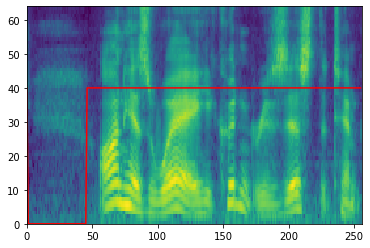

In [53]:
data = dataset[1]
plt.plot(data['targets'].numpy()[0]*40, color='red')
plt.pcolormesh(data['spectro'].numpy()[0])

In [4]:
import torch as th
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out, ks=(3, 3), s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(ch_in, ch_out, ks, s, p)
        self.bn = nn.BatchNorm2d(ch_out)
        self.act = nn.PReLU()
        self.mp = nn.MaxPool2d(kernel_size=[2, 1])

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.mp(x)
        return x


class CNNEmbedder(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.convblock1 = ConvBlock(ch_in, ch_out)
        self.convblock2 = ConvBlock(ch_out, ch_out)
        self.convblock3 = ConvBlock(ch_out, ch_out)
        self.convblock4 = ConvBlock(ch_out, ch_out)
    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        return x


class VADNet(nn.Module):
    def __init__(self, n_feat=256, cnn_channels=32, embed_dim=256, num_heads=16):
        super().__init__()
        self.cnn_embedder = CNNEmbedder(ch_in=1, ch_out=cnn_channels) 
        self.fc1 = nn.Linear(in_features=int((n_feat/16)*cnn_channels), out_features=embed_dim)
        self.self_attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=512),
            nn.Linear(in_features=512, out_features=256)
        )
        self.fc2 = nn.Linear(in_features=256, out_features=1)
        
    def forward(self, x):
        x = self.cnn_embedder(x)
        x = th.flatten(x, start_dim=1, end_dim=2)
        x = x.permute(0, 2, 1)
        x = res = self.fc1(x)
        x, _ = self.self_attention(x, x, x)
        x += res
        x = res = self.layer_norm1(x)
        x = self.mlp(x)
        x += res
        x = self.layer_norm2(x)
        x = self.fc2(x)
        return x

In [5]:
model = VADNet(n_feat=128)

In [6]:
x = th.randn((2, 1, 128, 256))

In [7]:
probs = model(x)
probs.shape

torch.Size([2, 256, 1])

#### test PT Lightning model 

In [36]:
import yaml
import argparse
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from model import *
from data import *



cfg = yaml.load(open('./configs/128_mels.yml'), Loader=yaml.FullLoader)

model = VAD(cfg)



In [8]:
path_list = glob(os.path.join(str('/home/virgile/data/vad_data_augmented/'), '*.wav'))

In [9]:
dataset = MelVADDataset(path_list, 
                        n_frames=256, 
                        nfft=1024, 
                        hop_length=512, 
                        n_mels=128, 
                        sr=16000,  
                        norm=False)

In [10]:
batch = dataset[1]

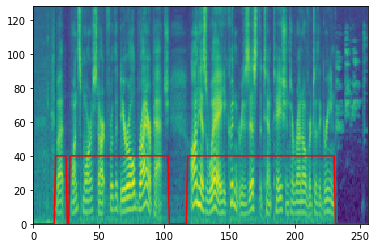

In [11]:
data = batch
plt.plot(data['targets'].numpy()[0]*40, color='red')
plt.pcolormesh(data['spectro'].numpy()[0])

In [17]:
probs = model(data['spectro'].unsqueeze(0)).squeeze(-1)

In [18]:
probs.shape

torch.Size([1, 256])

In [19]:
data['targets'].shape

torch.Size([1, 256])

In [30]:

import torchmetrics as tm
auroc = tm.AUROC(num_classes=1)

In [31]:
auroc(probs.squeeze(0), data['targets'].int().squeeze(0), )

tensor(0.2673)

In [1]:
from model import VAD

/home/virgile/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/virgile/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/virgile/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/virgile/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [77]:
import matplotlib.pyplot as plt
import argparse
import torch as th
import yaml
import os

from model import *


class VADPredictor(object):
    def __init__(self, ckpt_folder, device) -> None:
        super().__init__()

        self.ckpt_folder = ckpt_folder
        self.cfg = yaml.load(open(os.path.join(ckpt_folder, 'hparams.yml')), Loader=yaml.FullLoader)
        self.model = self.load_model()
        self.EPS = 1e-8

    def load_model(self):
        model = VAD(self.cfg)
        state_dict = th.load(os.path.join(self.ckpt_folder, 'last.ckpt'))['state_dict']
        model.load_state_dict(state_dict)
        return model

    def get_mel_spec(self, input_audio):
        audio, _ = torchaudio.load(input_audio)
        melspec_params = {
            'sample_rate':  self.cfg['data']['sr'],
            'n_fft' : self.cfg['data']['nfft'],
            'hop_length' :  self.cfg['data']['hop_length'],
            'n_mels' : self.cfg['data']['n_mels'],
        }
        melspec = torchaudio.transforms.MelSpectrogram(**melspec_params)
        mel = th.log(melspec(audio)+self.EPS)
        return mel

    def predict(self, audio_path, threshold):
        mel = self.get_mel_spec(audio_path)
        with th.no_grad():
            probs = th.sigmoid(self.model(mel.unsqueeze(0)))
            probs = probs[0, :, 0].detach().numpy()
        
        probs[probs >= threshold] = 1
        probs[probs < threshold] = 0

        return probs

    def plot_result(self, audio_path, threshold):
        mel = self.get_mel_spec(audio_path)
        probs = self.predict(audio_path, threshold)

        plt.plot(probs*40, color=('red'))
        plt.pcolormesh(mel[0].numpy())

        return probs

In [78]:
predictor = VADPredictor(ckpt_folder='./checkpoints/128_mels/', device='cpu')

/home/virgile/.local/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [79]:
input_file = "/data/LibriSpeech/test-clean/1995/1826/1995-1826-0001.flac"

In [80]:
probs = predictor.predict(audio_path=input_file, threshold=0.5)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

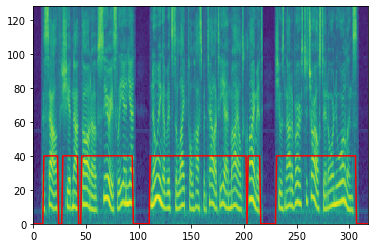

In [83]:
predictor.plot_result(audio_path=input_file, threshold=0.7)

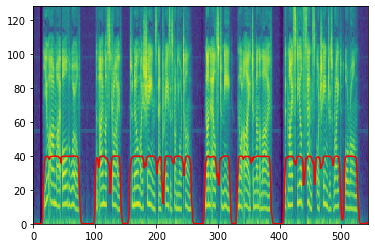

In [63]:
plt.plot(probs*40, color=('red'))
plt.pcolormesh(mel[0].numpy())